In [1]:
import pickle
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Keras library
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

# Different CNN Model
from keras.applications import VGG16, InceptionV3, MobileNetV2, DenseNet121

# To chain two different data augmented images for training
from itertools import chain

#  Distributed Computing
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\PC\AppData\Local\Temp\ipykernel_10384\3468691982.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )
print('Data Augmentation 2 was created')

Data Augmentation 1 was created
Data Augmentation 2 was created


In [3]:
data_generator_3 = ImageDataGenerator(rescale=1./255)

train_generator1 = data_generator_1.flow_from_directory(
    directory=r"C:\Users\PC\OneDrive\Desktop\pneumonia_detection\data\data\Train",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

print('Data Augmentation 1 was used to generate the train data set\n')

test_generator = data_generator_3.flow_from_directory(
    directory=r"C:\Users\PC\OneDrive\Desktop\pneumonia_detection\data\data\Test",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

Found 4148 images belonging to 3 classes.
Data Augmentation 1 was used to generate the train data set

Found 300 images belonging to 3 classes.


In [4]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'BAC_PNEUMONIA': 0, 'NORMAL': 1, 'VIR_PNEUMONIA': 2}
Class labels: ['BAC_PNEUMONIA', 'NORMAL', 'VIR_PNEUMONIA']


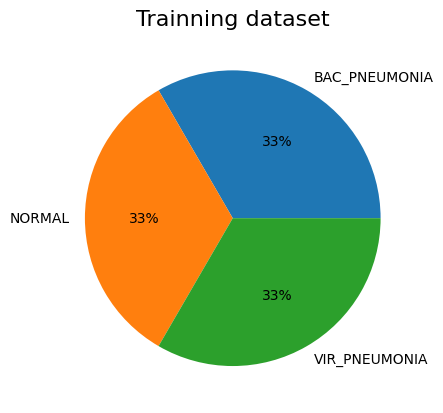

In [5]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [6]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator1.classes))
print("Number of bacterial pneumonia images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of normal images:", len([label for label in train_generator1.classes if label == 1]))
print("Number of viral pneumonia images:", len([label for label in train_generator1.classes if label == 2]))
print()

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of bacterial pneumonia images:", len([label for label in test_generator.classes if label == 0]))
print("Number of normal images:", len([label for label in test_generator.classes if label == 1]))
print("Number of viral pneumonia images:", len([label for label in test_generator.classes if label == 2]))
print()

Dataset Characteristics of Train Data Set:
Number of images: 4148
Number of bacterial pneumonia images: 1384
Number of normal images: 1380
Number of viral pneumonia images: 1384

Dataset Characteristics of Test Data Set:
Number of images: 300
Number of bacterial pneumonia images: 100
Number of normal images: 100
Number of viral pneumonia images: 100



In [7]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 0.9990366088631984, 1: 1.0019323671497584, 2: 0.9990366088631984}

Train image data from Data Augmentation 1


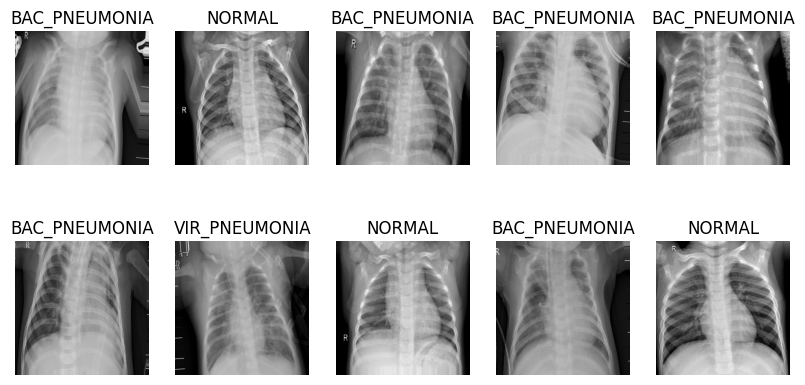

In [8]:
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[10, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])
plt.show()

In [9]:
# Define the epochs for training
EPOCHS = 4

# Define the number of GPUs to use
num_gpus = 2

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)

train_data = train_generator1


In [10]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained VGG16 model without the top classification layer
    base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_VGG16.layers:
        layer.trainable = False

    # Create a new model and add the VGG16 base model
    model_VGG16 = Sequential()
    model_VGG16.add(base_model_VGG16)

    # Add a fully connected layer and output layer for classification
    model_VGG16.add(GlobalAveragePooling2D())
    model_VGG16.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model_VGG16.add(Dropout(0.4))
    model_VGG16.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model_VGG16.add(Dropout(0.2))
    model_VGG16.add(Dense(3, activation='softmax'))


    # Model summary
    print("Model Summary (VGG16):")
    model_VGG16.summary()
    print()

    # Compile the model
    model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_VGG16 = model_VGG16.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_VGG16, val_accuracy_VGG16 = model_VGG16.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_VGG16:.4f}')
    print(f'Validation Accuracy: {val_accuracy_VGG16:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)




Model Summary (VGG16):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                               

In [12]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained MobileNetV2 model without the top classification layer
    base_model_MobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_MobileNet.layers:
        layer.trainable = False

    # Create a new model and add the MobileNetV2 base model
    model_MobileNet = Sequential()
    model_MobileNet.add(base_model_MobileNet)

    # Add a global average pooling layer and output layer for classification
    model_MobileNet.add(GlobalAveragePooling2D())
    model_MobileNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_MobileNet.add(Dropout(0.4))
    model_MobileNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_MobileNet.add(Dropout(0.2))
    model_MobileNet.add(Dense(3, activation='softmax'))

    # Model summary
    print("Model Summary (MobileNetV2):")
    model_MobileNet.summary()
    print()

    # Compile the model
    model_MobileNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_MobileNet = model_MobileNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_MobileNet, val_accuracy_MobileNet = model_MobileNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_MobileNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_MobileNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (MobileNetV2):
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                

In [13]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained DenseNet121 model without the top classification layer
    base_model_DenseNet = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_DenseNet.layers:
        layer.trainable = False

    # Create a new model and add the DenseNet121 base model
    model_DenseNet = Sequential()
    model_DenseNet.add(base_model_DenseNet)

    # Add a global average pooling layer and output layer for classification
    model_DenseNet.add(GlobalAveragePooling2D())
    model_DenseNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_DenseNet.add(Dropout(0.4))
    model_DenseNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_DenseNet.add(Dropout(0.2))
    model_DenseNet.add(Dense(3, activation='softmax'))

    # Model summary
    print("Model Summary (DenseNet121):")
    model_DenseNet.summary()
    print()

    # Compile the model
    model_DenseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_DenseNet = model_DenseNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_DenseNet, val_accuracy_DenseNet = model_DenseNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_DenseNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_DenseNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (DenseNet121):
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 9, 9, 1024)        7037504   
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 128)               131200    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                       

In [14]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained InceptionV3 model without the top classification layer
    base_model_Inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_Inception.layers:
        layer.trainable = False

    # Create a new model and add the InceptionV3 base model
    model_Inception = Sequential()
    model_Inception.add(base_model_Inception)

    # Add a global average pooling layer and output layer for classification
    model_Inception.add(GlobalAveragePooling2D())
    model_Inception.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_Inception.add(Dropout(0.4))
    model_Inception.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_Inception.add(Dropout(0.2))

    model_Inception.add(Dense(3, activation='softmax'))

    # Model summary
    print("Model Summary (InceptionV3):")
    model_Inception.summary()
    print()

    # Compile the model
    model_Inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with EarlyStopping
    history_Inception = model_Inception.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_Inception, val_accuracy_Inception = model_Inception.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_Inception:.4f}')
    print(f'Validation Accuracy: {val_accuracy_Inception:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (InceptionV3):
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                       

In [15]:
data = {
    'VGG16': val_accuracy_VGG16,
    'MobileNet': val_accuracy_MobileNet,
    'DenseNet': val_accuracy_DenseNet,
    'Inception': val_accuracy_Inception
}

In [16]:
df = pd.DataFrame.from_dict(data, orient='index', columns=['accuracy'])
df = df.reset_index().rename(columns={'index': 'model'})

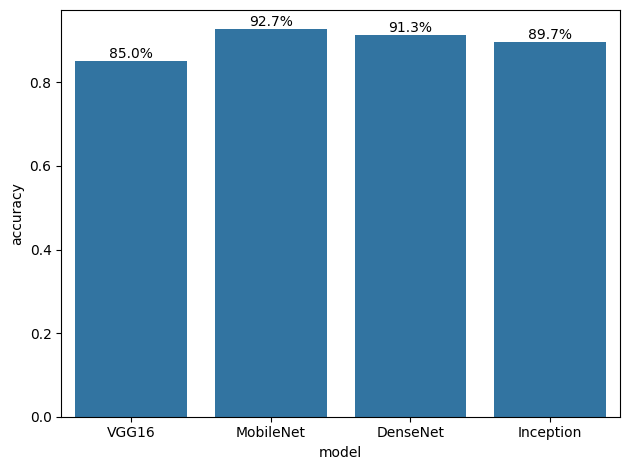

In [17]:
# Create bar chart
sns.barplot(x='model', y='accuracy', data=df)

# Add labels to bars
ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=10)

# Adjust the layout
plt.tight_layout()

plt.show()

In [18]:
# Fine-tune the model with frozen layers

# Unfreeze the base_model
no_base_layers = len(model_MobileNet.layers)
print('No. of base layers in the model = {}\n'.format(no_base_layers))

# no of layers for fine-tune
no_finetune_layers = int(no_base_layers/2)
print('No. of layers for fine-tune = {}'.format(no_finetune_layers))

No. of base layers in the model = 7

No. of layers for fine-tune = 3


In [19]:
# Fine-tune the model
model_MobileNet.trainable = True
for layer in model_MobileNet.layers[: -no_finetune_layers]:
    layer.trainable = False

# small learning rate for fine tuning
model_MobileNet.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune_MobileNet = model_MobileNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/4
87/87 [==============================] - 142s 2s/step - loss: 0.5496 - accuracy: 0.8252 - val_loss: 0.4271 - val_accuracy: 0.9267
Epoch 2/4
87/87 [==============================] - 137s 2s/step - loss: 0.5461 - accuracy: 0.8303 - val_loss: 0.4265 - val_accuracy: 0.9267
Epoch 3/4
87/87 [==============================] - 137s 2s/step - loss: 0.5435 - accuracy: 0.8240 - val_loss: 0.4261 - val_accuracy: 0.9333
Epoch 4/4
87/87 [==============================] - 139s 2s/step - loss: 0.5558 - accuracy: 0.8255 - val_loss: 0.4259 - val_accuracy: 0.9333


In [20]:
# Validate the model
print('====== Model Validation ======')
val_loss_finetune_MobileNet, val_accuracy_finetune_MobileNet = model_MobileNet.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_finetune_MobileNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_finetune_MobileNet:.4f}')

====== Model Validation ======
7/7 [==============================] - 8s 997ms/step - loss: 0.4259 - accuracy: 0.9333
Validation Loss: 0.4259
Validation Accuracy: 0.9333


In [21]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
MobileNet_test_preds = model_MobileNet.predict(test_generator)
MobileNet_test_pred_classes = np.argmax(MobileNet_test_preds, axis=1)

7/7 [==============================] - 8s 985ms/step


2/2 [==============================] - 2s 358ms/step


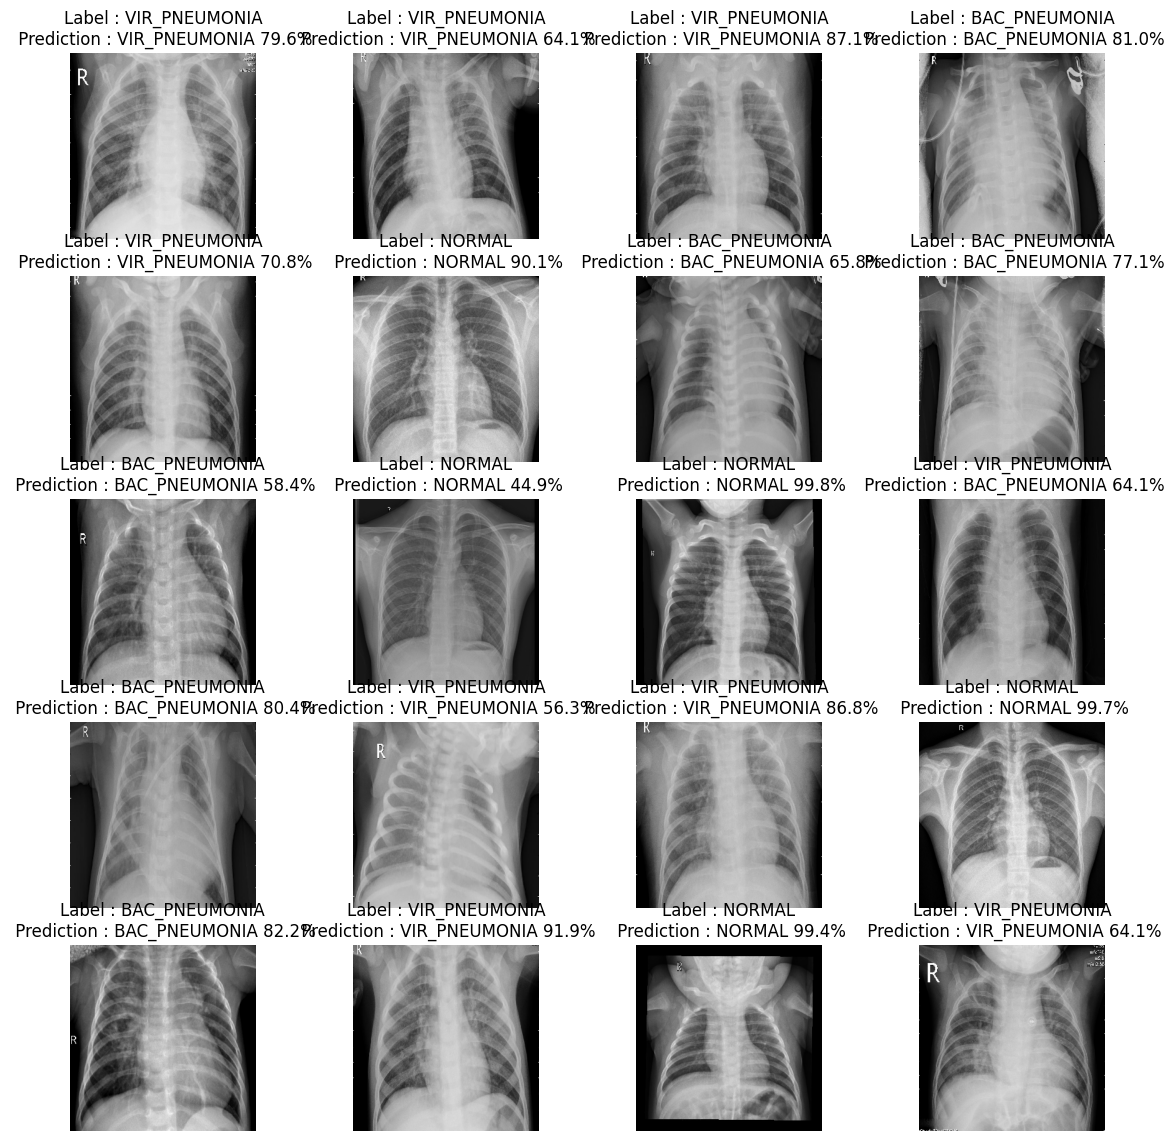

In [22]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_MobileNet.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

In [23]:
test_dir = r"C:\Users\PC\OneDrive\Desktop\pneumonia_detection\data\data\Test"

# Image dimensions
image_height = 299
image_width = 299

# Create ImageDataGenerator for test data
test_data_generator = ImageDataGenerator(rescale=1./255)

# Load test data using the generator
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=1,
    shuffle=False,  # Important: Set shuffle to False to maintain order
    class_mode='categorical'
)

# Get predictions and true labels
y_pred = model_MobileNet.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
file_names = test_generator.filenames

# Identify mispredicted indices
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Print file names of mispredicted images
print("\nMispredicted File Names:")
for idx in misclassified_indices:
    print(file_names[idx])

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Classification Report
class_names = list(test_generator.class_indices.keys())
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)

# Display Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Display Classification Report
print("\nClassification Report:")
print(class_report)

Found 300 images belonging to 3 classes.


300/300 [==============================] - 7s 23ms/step

Mispredicted File Names:
BAC_PNEUMONIA\person108_bacteria_511.jpeg
BAC_PNEUMONIA\person113_bacteria_543.jpeg
BAC_PNEUMONIA\person117_bacteria_557.jpeg
BAC_PNEUMONIA\person88_bacteria_439.jpeg
NORMAL\IM-0022-0001.jpeg
NORMAL\IM-0039-0001.jpeg
NORMAL\IM-0073-0001.jpeg
NORMAL\IM-0075-0001.jpeg
NORMAL\IM-0079-0001.jpeg
NORMAL\IM-0101-0001.jpeg
NORMAL\IM-0110-0001.jpeg
NORMAL\NORMAL2-IM-0107-0001.jpeg
VIR_PNEUMONIA\person1608_virus_2786.jpeg
VIR_PNEUMONIA\person1623_virus_2813.jpeg
VIR_PNEUMONIA\person1650_virus_2854.jpeg
VIR_PNEUMONIA\person1655_virus_2861.jpeg
VIR_PNEUMONIA\person1674_virus_2890.jpeg
VIR_PNEUMONIA\person49_virus_101.jpeg
VIR_PNEUMONIA\person60_virus_117.jpeg
VIR_PNEUMONIA\person77_virus_139.jpeg
Confusion Matrix:
[[96  2  2]
 [ 5 92  3]
 [ 2  6 92]]

Classification Report:
               precision    recall  f1-score   support

BAC_PNEUMONIA       0.93      0.96      0.95       100
       NORMAL       0.92      0.92

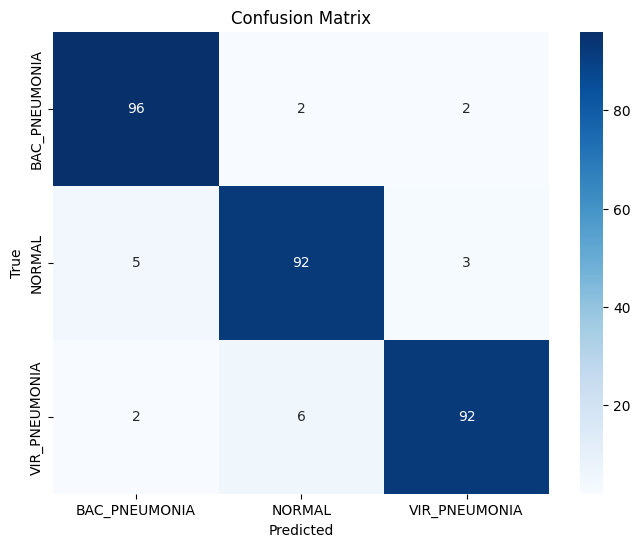

Classification Report:
               precision    recall  f1-score   support

BAC_PNEUMONIA       0.93      0.96      0.95       100
       NORMAL       0.92      0.92      0.92       100
VIR_PNEUMONIA       0.95      0.92      0.93       100

     accuracy                           0.93       300
    macro avg       0.93      0.93      0.93       300
 weighted avg       0.93      0.93      0.93       300



In [24]:
# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print Classification Report
print('Classification Report:')
print(class_report)

In [ ]:

'''
# Save model architecture to JSON file
model_json = model_MobileNet.to_json()
with open("Mobile_classifier.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 file
model_MobileNet.save_weights("Mobile_classifier_weights.h5")

'''

'\n# Save model architecture to JSON file\nmodel_json = model_MobileNet.to_json()\nwith open("Mobile_classifier.json", "w") as json_file:\n    json_file.write(model_json)\n\n# Save model weights to HDF5 file\nmodel_MobileNet.save_weights("Mobile_classifier_weights.h5")\n\n'

In [25]:
model_MobileNet.save("Mobile-model.h5")
#https://heartbeat.comet.ml/converting-tensorflow-keras-models-built-in-python-to-javascript-4ae4f7bcac86
#https://www.youtube.com/watch?v=yWBM2-Rx47M
#https://medium.com/@mandava807/importing-a-keras-model-into-tensorflow-js-b09600a95e40

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
